In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras 
from keras import layers

In [ ]:
SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tensorflow.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [ ]:

BATCH_SIZE = 25
DATA_DIR = ('/content/drive/MyDrive/Lung Dataset')
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)
validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)



Found 5073 files belonging to 3 classes.
Using 4059 files for training.
Found 5073 files belonging to 3 classes.
Using 1014 files for validation.


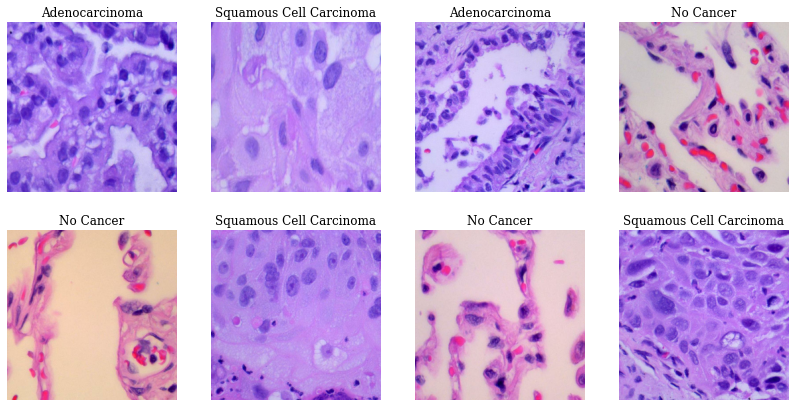

In [ ]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [ ]:
# Cache and prefetch data for faster training
AUTOTUNE = tensorflow.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: keras.Sequential) -> tensorflow.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

In [ ]:
#Model with VGG16 base

pretrained_vgg16_base = tensorflow.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tensorflow.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tensorflow.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 14,780,739
Trainable params: 66,051
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/25
163/163 [==============================] - 1143s 7s/step - loss: 0.2282 - accuracy: 0.9229 - val_loss: 0.1443 - val_accuracy: 0.9458 - lr: 0.0010
Epoch 2/25
163/163 [==============================] - 28s 171ms/step - loss: 0.0922 - accuracy: 0.9648 - val_loss: 0.0989 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 3/25
163/163 [==============================] - 29s 176ms/step - loss: 0.0619 - accuracy: 0.9766 - val_loss: 0.0960 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 4/25
163/163 [==============================] - 29s 178ms/step - loss: 0.0469 - accuracy: 0.9832 - val_loss: 0.1048 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 5/25
163/163 [==============================] - 30s 183ms/step - loss: 0.0444 - accuracy: 0.9820 - val_loss: 0.0978 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 6/25
163/163 [==============================] - 29s 180ms/step - loss: 0.0397 - accuracy: 0.9852 - val_loss: 0.0767 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 7/25
163/163 [==============================] -

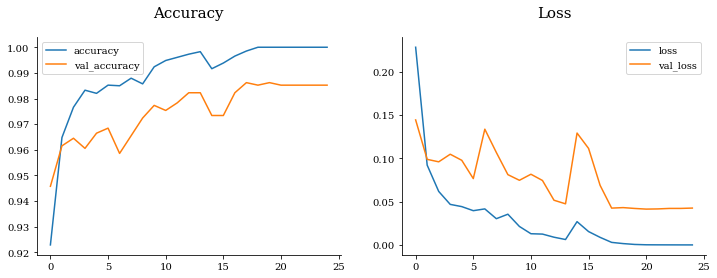

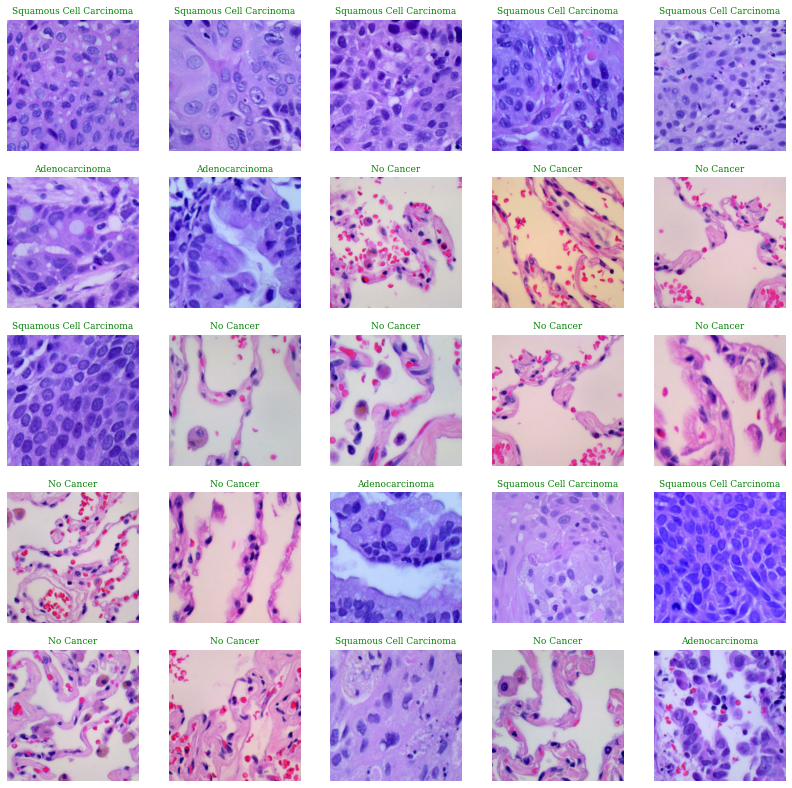

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_model)
plot_predictions(vgg16_model)